<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/SystemIdentification_for_DiscreteMarkovProcesses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##__Introduction__

The aim of this notebook is to provide an introduction to Markov chains and the estimation of transition matrices from process time data.
In particular, two cases are shown, one with a controllable system and one not.

---
__CORE DEPENDENCIES__  
numpy: 1.25.2  
matplotlib: 3.7.1  
pywt: 1.6.0

In [1]:
# @title #####__IMPORTS__

import numpy as np
import matplotlib.pyplot as plt
import pywt

#print(pywt.__version__)

##__Markov Process__

###__Markov Process Data Generation__

This section generates observed transactions for multiple series based on a predefined transition probability matrix. It then plots the observed transactions for visualization.  
The system under consideration responds to a Markov Process.  
 A Markov process, also known as a Markov chain, is a stochastic model that describes a sequence of events where the probability of each event depends only on the state attained in the previous event.
Formally, a Markov process is defined by a set of states, a transition probability matrix describing the probabilities of moving from one state to another, and an initial state distribution.

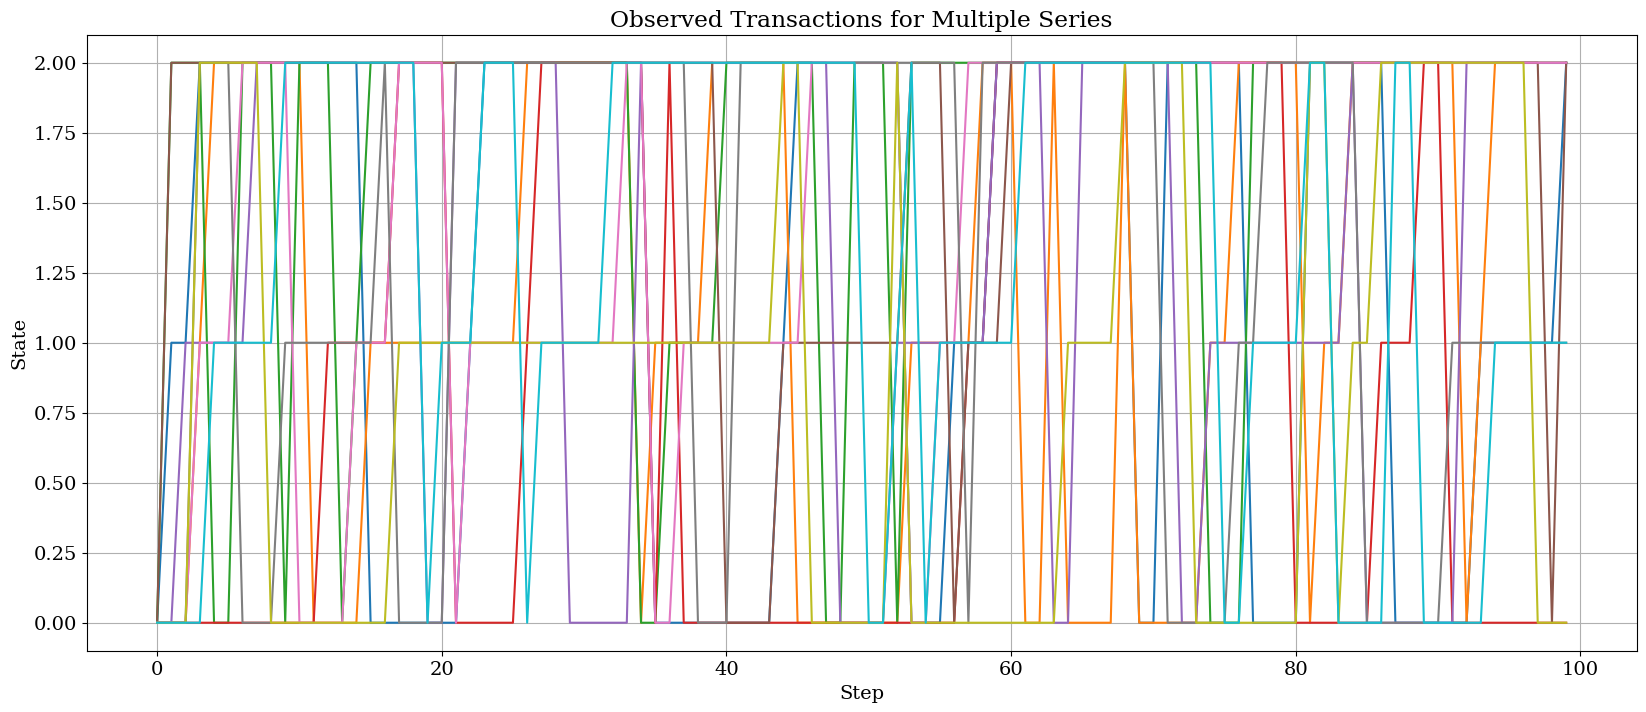

In [2]:
# @title #####__DATA GENERATION FOR SYSTEM IDENTIFICATION__

initial_state = 0
num_steps = 100  # Define the number of steps for each series
num_series = 10  # Define the number of series
states = [0, 1, 2]  # Define the states
transition_probabilities_true = np.array([
    [7.42857143e-01, 1.57142857e-01, 1.00000000e-01],
    [1.88679245e-10, 8.49056603e-01, 1.50943396e-01],
    [1.02564103e-01, 2.56410256e-10, 8.97435897e-01]])

np.random.seed(8989)
observed_transactions_all = []

# Generate observed transactions for each series
for i in range(num_series):
    current_state = initial_state

    # Data structure to store observed transactions for this series
    observed_transactions_series = []

    # Simulation loop for this series
    for t in range(num_steps):
        observed_transactions_series.append(np.random.choice(states, p=transition_probabilities_true[current_state]))
        current_state = observed_transactions_series[-1]

    observed_transactions_all.append(observed_transactions_series)

observed_transactions_all = np.array(observed_transactions_all)

# Plot all series in a global plot
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
for i in range(num_series):
    plt.plot(observed_transactions_all[i], label=f"Series {i+1}")

plt.xlabel('Step')
plt.ylabel('State')
plt.title('Observed Transactions for Multiple Series')
plt.grid(True)
plt.show()


observed_transitions = observed_transactions_all

###**Maximum Likelihood Estimation (MLE):**

MLE is a method used in statistics to estimate the parameters of a statistical model.
The goal is to find the parameter values that maximize the likelihood function, which measures how well the model explains the observed data.
Mathematically, if we have a likelihood function
L(θ∣X), where θ represents the parameters of the model and X represents the observed data, MLE seeks to find the value of θ that maximizes L.  

Citing: http://docs.markovmodel.org/lecture_ml_nonrev.html  
The maximum likelihood estimator is identical to the intuitive fraction of counts: \begin{align*} p_{ij} = \frac{c_{ij}}{\sum_{k=1}^{n} c_{ik}} \end{align*}


In [3]:
# @title #####__SYSTEM TRANSITION PROBABILITIES MATRIX ESTIMATION W/ MAX LIKELIHOOD METHOD (MLE)__


# Define states
states = [0, 1, 2]
num_states = len(states)

# Initialize transition count matrix
transition_counts = np.zeros((num_states, num_states), dtype=int)

# Count transitions
for sequence in observed_transitions:
    for i in range(len(sequence) - 1):
        from_state = states.index(sequence[i])
        to_state = states.index(sequence[i + 1])
        transition_counts[from_state, to_state] += 1

# Define epsilon for smoothing
epsilon = 1e-8

# Normalize counts to obtain transition probabilities with smoothing
transition_probabilities_mle = (transition_counts + epsilon).astype(float)
for i in range(num_states):
    row_sum = np.sum(transition_counts[i, :]) + epsilon * num_states
    transition_probabilities_mle[i, :] /= row_sum

# Output transition probability matrix
print("MLE Estimated Transition Probability Matrix:")
print(transition_probabilities_mle)

# Simulate transitions using the estimated matrix
initial_state = 0 # Initial state for simulation
num_steps = 20  # Number of time steps to simulate

# Simulate transitions
np.random.seed(8989)
current_state = initial_state
print("\nSimulated System:")
for t in range(num_steps):
    print(f"Step {t}: {current_state}")
    current_state = np.random.choice(states, p=transition_probabilities_mle[states.index(current_state)])

# Output final state
print(f"Final state after {num_steps} steps: {current_state}")


MLE Estimated Transition Probability Matrix:
[[7.40157480e-01 1.61417323e-01 9.84251969e-02]
 [5.10204082e-11 8.01020408e-01 1.98979592e-01]
 [1.07407407e-01 1.85185185e-11 8.92592593e-01]]

Simulated System:
Step 0: 0
Step 1: 0
Step 2: 1
Step 3: 1
Step 4: 2
Step 5: 2
Step 6: 2
Step 7: 2
Step 8: 2
Step 9: 2
Step 10: 2
Step 11: 2
Step 12: 2
Step 13: 2
Step 14: 2
Step 15: 2
Step 16: 0
Step 17: 0
Step 18: 0
Step 19: 0
Final state after 20 steps: 0


###**Wavelet-Based Maximum Likelihood Estimation (WMLE):**

This is an extension of MLE that incorporates wavelet transforms, which are mathematical functions used for signal processing and analysis.
In wavelet-based MLE, the likelihood function is computed in the wavelet domain, allowing for more efficient estimation in certain cases, especially when dealing with signals or data that exhibit specific frequency characteristics.  
In this application the code first performs wavelet decomposition on observed transitions, updates transition counts using approximation coefficients, and finally normalizes counts to obtain transition probabilities with smoothing.

In [4]:
# @title #####__SYSTEM TRANSITION PROBABILITIES MATRIX ESTIMATION W/ WAVELET BASED MAX LIKELIHOOD METHOD (WMLE)__

# Define states
states = [0, 1, 2]
num_states = len(states)

# Create a dictionary to map states to their indices
state_indices = {state: i for i, state in enumerate(states)}

# Initialize transition count matrix
transition_counts = np.zeros((num_states, num_states), dtype=int)

# Count transitions
for sequence in observed_transitions:
    sequence = np.array(sequence, dtype=int)  # Convert to integers
    for i in range(len(sequence) - 1):
        from_state = state_indices.get(sequence[i])
        to_state = state_indices.get(sequence[i + 1])
        if from_state is not None and to_state is not None:
            transition_counts[from_state, to_state] += 1

# Perform wavelet decomposition on observed transitions
coeffs = pywt.wavedec(observed_transitions, 'db2' , mode='constant', level=5)  #'haar'

# Extract approximation coefficients for transition estimation
approx_coeffs = np.array(coeffs[0])

# Update transition counts using approximation coefficients
for sequence in approx_coeffs:
    sequence = np.array(sequence, dtype=int)  # Convert to integers
    for i in range(len(sequence) - 1):
        from_state = state_indices.get(sequence[i])
        to_state = state_indices.get(sequence[i + 1])
        if from_state is not None and to_state is not None:
            transition_counts[from_state, to_state] += 1

# Define epsilon for smoothing
epsilon = 1e-8

# Normalize counts to obtain transition probabilities with smoothing
transition_probabilities_wmle = (transition_counts + epsilon).astype(float)
for i in range(num_states):
    row_sum = np.sum(transition_counts[i, :]) + epsilon * num_states
    transition_probabilities_wmle[i, :] /= row_sum

# Output transition probability matrix
print("WMLE Estimated Transition Probability Matrix:")
print(transition_probabilities_wmle)

# Simulate transitions using the estimated matrix
initial_state = 0 # Initial state for simulation
num_steps = 20  # Number of time steps to simulate

# Simulate transitions
np.random.seed(8989)
current_state = initial_state
print("\nSimulated System:")
for t in range(num_steps):
    print(f"Step {t}: {current_state}")
    current_state = np.random.choice(states, p=transition_probabilities_wmle[current_state])

# Output final state
print(f"Final state after {num_steps} steps: {current_state}")


WMLE Estimated Transition Probability Matrix:
[[7.43295019e-01 1.60919540e-01 9.57854406e-02]
 [5.10204082e-11 8.01020408e-01 1.98979592e-01]
 [1.07407407e-01 1.85185185e-11 8.92592593e-01]]

Simulated System:
Step 0: 0
Step 1: 0
Step 2: 1
Step 3: 1
Step 4: 2
Step 5: 2
Step 6: 2
Step 7: 2
Step 8: 2
Step 9: 2
Step 10: 2
Step 11: 2
Step 12: 2
Step 13: 2
Step 14: 2
Step 15: 2
Step 16: 0
Step 17: 0
Step 18: 0
Step 19: 0
Final state after 20 steps: 0


True Matrix:

[[7.42857143e-01 1.57142857e-01 1.00000000e-01]
 [1.88679245e-10 8.49056603e-01 1.50943396e-01]
 [1.02564103e-01 2.56410256e-10 8.97435897e-01]]

Max Likelihood Estimated Matrix:

[[7.40157480e-01 1.61417323e-01 9.84251969e-02]
 [5.10204082e-11 8.01020408e-01 1.98979592e-01]
 [1.07407407e-01 1.85185185e-11 8.92592593e-01]]

Wavelet Max Likelihood Estimated Matrix:

[[7.43295019e-01 1.60919540e-01 9.57854406e-02]
 [5.10204082e-11 8.01020408e-01 1.98979592e-01]
 [1.07407407e-01 1.85185185e-11 8.92592593e-01]]



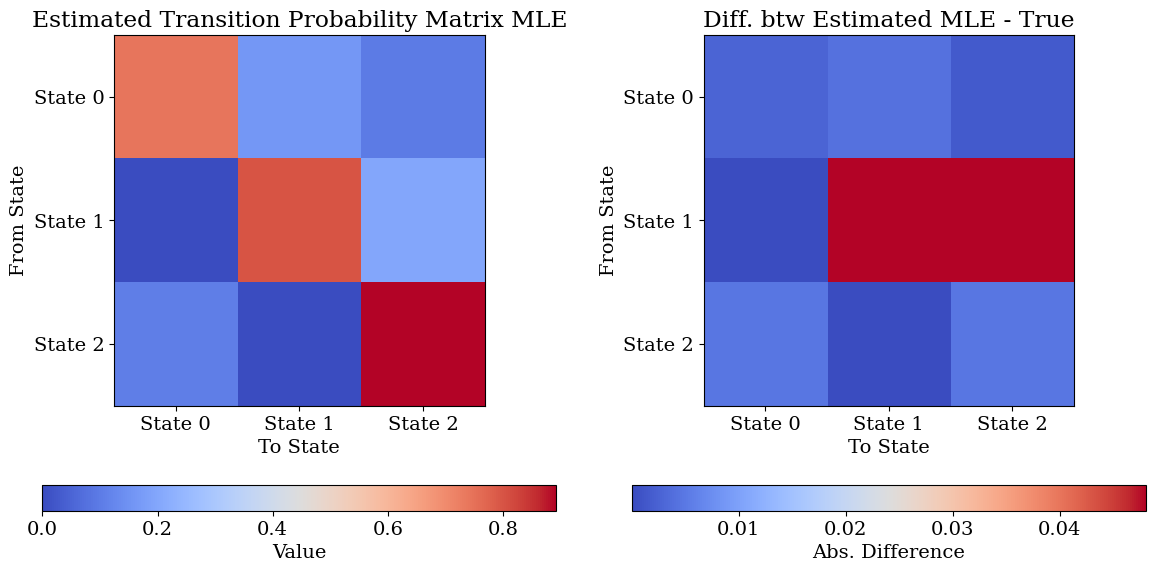

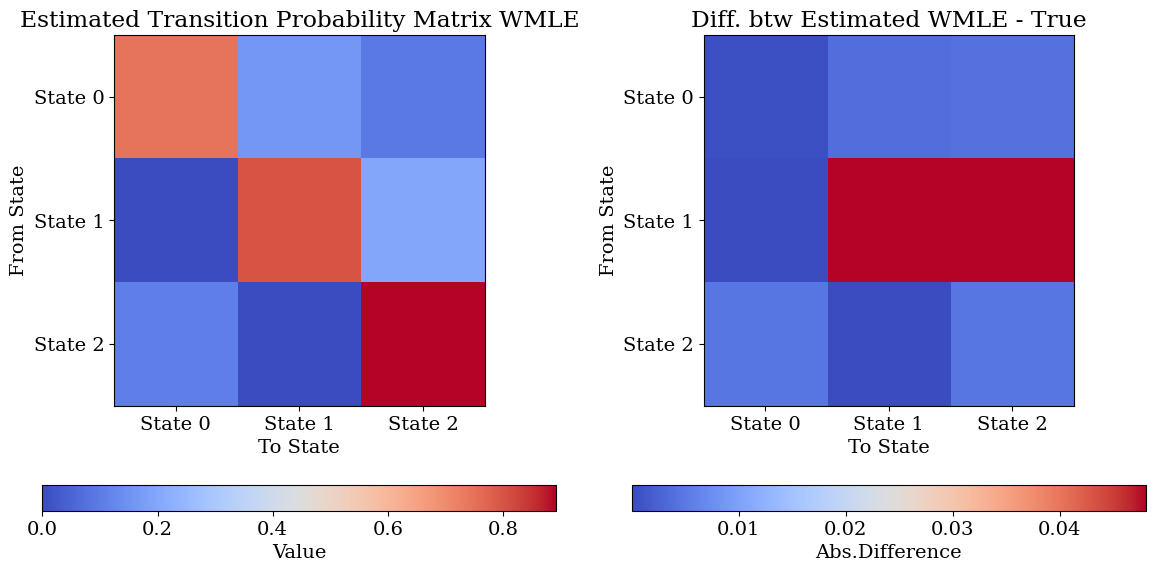

In [5]:
# @title #####__PLOT ESTIMATED TRANSITION PROBABILITY MATRIX W/ ABS ERROR__

print('True Matrix:'), print()
print(transition_probabilities_true), print()
print('Max Likelihood Estimated Matrix:'), print()
print(transition_probabilities_mle), print()
print('Wavelet Max Likelihood Estimated Matrix:'), print()
print(transition_probabilities_wmle), print()


difference_matrix_mle = np.abs(transition_probabilities_mle - transition_probabilities_true)
# Plot the difference matrix as a colored grid
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot estimated transition probability matrix
axes[0].imshow(transition_probabilities_mle, cmap='coolwarm', interpolation='nearest')
axes[0].set_title('Estimated Transition Probability Matrix MLE')
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From State')
axes[0].set_xticks(np.arange(3))
axes[0].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[0].set_yticks(np.arange(3))
axes[0].set_yticklabels(['State 0', 'State 1', 'State 2'])
axes[0].grid(False)
plt.colorbar(axes[0].imshow(transition_probabilities_mle, cmap='coolwarm', interpolation='nearest'), ax=axes[0], label='Value', orientation='horizontal')

# Plot difference matrix
im = axes[1].imshow(difference_matrix_mle, cmap='coolwarm', interpolation='nearest')
axes[1].set_title('Diff. btw Estimated MLE - True')
axes[1].set_xlabel('To State')
axes[1].set_ylabel('From State')
axes[1].set_xticks(np.arange(3))
axes[1].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[1].set_yticks(np.arange(3))
axes[1].set_yticklabels(['State 0', 'State 1', 'State 2'])
axes[1].grid(False)
plt.colorbar(im, ax=axes[1], label='Abs. Difference', orientation='horizontal')

plt.tight_layout()
plt.show()


difference_matrix_wmle = np.abs(transition_probabilities_wmle - transition_probabilities_true)
# Plot the difference matrix as a colored grid
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot estimated transition probability matrix
axes[0].imshow(transition_probabilities_wmle, cmap='coolwarm', interpolation='nearest')
axes[0].set_title('Estimated Transition Probability Matrix WMLE')
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From State')
axes[0].set_xticks(np.arange(3))
axes[0].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[0].set_yticks(np.arange(3))
axes[0].set_yticklabels(['State 0', 'State 1', 'State 2'])
axes[0].grid(False)
plt.colorbar(axes[0].imshow(transition_probabilities_wmle, cmap='coolwarm', interpolation='nearest'), ax=axes[0], label='Value', orientation='horizontal')

# Plot difference matrix
im = axes[1].imshow(difference_matrix_wmle, cmap='coolwarm', interpolation='nearest')
axes[1].set_title('Diff. btw Estimated WMLE - True')
axes[1].set_xlabel('To State')
axes[1].set_ylabel('From State')
axes[1].set_xticks(np.arange(3))
axes[1].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[1].set_yticks(np.arange(3))
axes[1].set_yticklabels(['State 0', 'State 1', 'State 2'])
axes[1].grid(False)
plt.colorbar(im, ax=axes[1], label='Abs.Difference', orientation='horizontal')

plt.tight_layout()
plt.show()

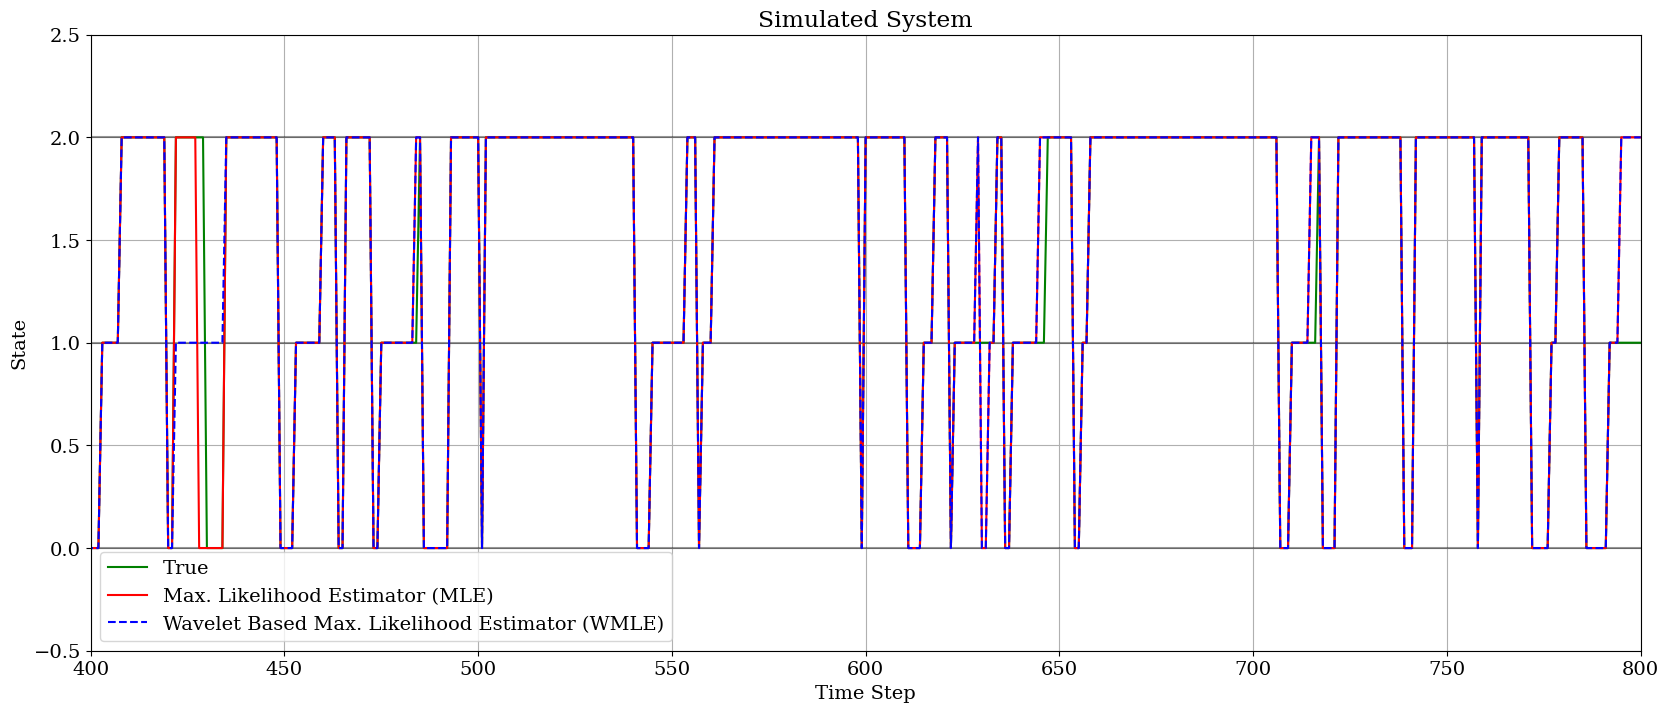

In [6]:
# @title #####__SIMULATE SYSTEM W/ ESTIMATED TRANSITION PROBABILITIES MATRIX MLE WMLE__

# Simulate transitions using the estimated matrices
initial_state = 0  # Initial state for simulation
num_steps = 800  # Number of time steps to simulate


np.random.seed(8989)
current_state_true = initial_state
simulated_states_true = [current_state_true]
for t in range(num_steps):
    current_state_true = np.random.choice(states, p=transition_probabilities_true[current_state_true])
    simulated_states_true.append(current_state_true)

# Simulate transitions for Markov estimator
np.random.seed(8989)
current_state_mle = initial_state
simulated_states_mle = [current_state_mle]
for t in range(num_steps):
    current_state_mle = np.random.choice(states, p=transition_probabilities_mle[current_state_mle])
    simulated_states_mle.append(current_state_mle)

# Simulate transitions for Wavelet-Markov estimator
np.random.seed(8989)
current_state_wmle = initial_state
simulated_states_wmle = [current_state_wmle]
for t in range(num_steps):
    current_state_wmle = np.random.choice(states, p=transition_probabilities_wmle[current_state_wmle])
    simulated_states_wmle.append(current_state_wmle)

# Plot the results
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
plt.hlines(0, 0, num_steps, colors='black', alpha=0.4)
plt.hlines(1, 0, num_steps, colors='black', alpha=0.4)
plt.hlines(2, 0, num_steps, colors='black', alpha=0.4)
plt.plot(simulated_states_true, label='True', color='green')
plt.plot(simulated_states_mle, label='Max. Likelihood Estimator (MLE)', color='red')
plt.plot(simulated_states_wmle, label='Wavelet Based Max. Likelihood Estimator (WMLE)', color='blue', linestyle='dashed')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.title('Simulated System')
plt.legend(loc='lower left')
plt.xlim((num_steps/2, num_steps))
plt.ylim((-0.5, 2.5))
plt.grid()
plt.show()



---



##__Markov Decision Process__

###__Markov Decision Process (MDP)__

MDP is an extension of the Markov process that includes decision-making.
In an MDP, an agent makes decisions at each step based on the current state and a set of available actions, aiming to maximize a cumulative reward over time.
The key components of an MDP are states, actions, transition probabilities, rewards, and a discount factor.
MDPs are fundamental in the field of reinforcement learning, where agents learn to make optimal decisions through interactions with an environment.   

What guides the agent to learn the optimal policy is the Value Function which is obtained from the Bellman Equation:

The Bellman equation is a fundamental concept in dynamic programming and optimal control theory.
It expresses the value of being in a certain state as the maximum expected cumulative reward that can be obtained from that state onwards.
Optimal control aims to find the control policy that maximizes the expected cumulative reward over time.
The Bellman equation provides a recursive way to compute the optimal value function, which represents the expected cumulative reward from each state, and the optimal policy, which specifies the best action to take in each state.
The "Bellman optimality equation" is used to find the optimal value function, and once the optimal value function is known, the optimal policy can be derived from it.

----
States:

>States represent the possible situations or configurations of a system at any given time.
In a Markov process or Markov decision process, states define the different situations the system can be in.  

Actions:

>Actions are the possible decisions or choices that an agent can make in a given state.
In a Markov decision process, agents choose actions based on the current state to influence future states.

Transition Probabilities:

>Transition probabilities specify the likelihood of moving from one state to another after taking a particular action.
In a Markov process or Markov decision process, these probabilities define the dynamics of the system.

Rewards:

>Rewards represent the immediate feedback or reinforcement received by an agent after taking an action in a certain state.
They quantify the desirability or utility of being in a particular state or taking a specific action.

Discount Factor:

>The discount factor is a parameter that trades off immediate rewards against future rewards.
It discounts the value of future rewards relative to immediate rewards.
A discount factor close to 1 emphasizes long-term rewards, while a discount factor close to 0 emphasizes immediate rewards.
These components collectively define the dynamics and objectives of a Markov decision process, allowing agents to make decisions that maximize cumulative rewards over time.  

---  
This application example shows a maintenance management case, where the states represent:  
- 0 -> Excellent Condition
- 1 -> Good Conditions
- 2 -> Poor Condition

And the control actions are:  
- 0 -> Do Nothing
- 1 -> Maintenance
- 2 -> Replacement


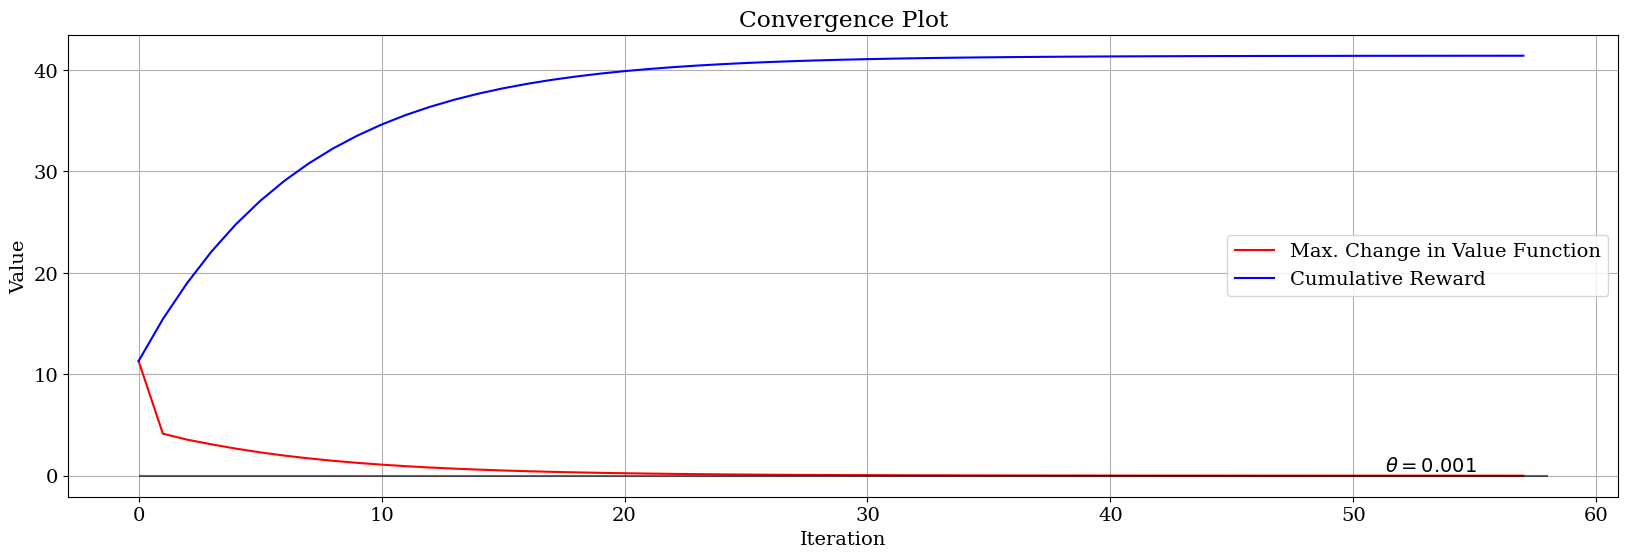

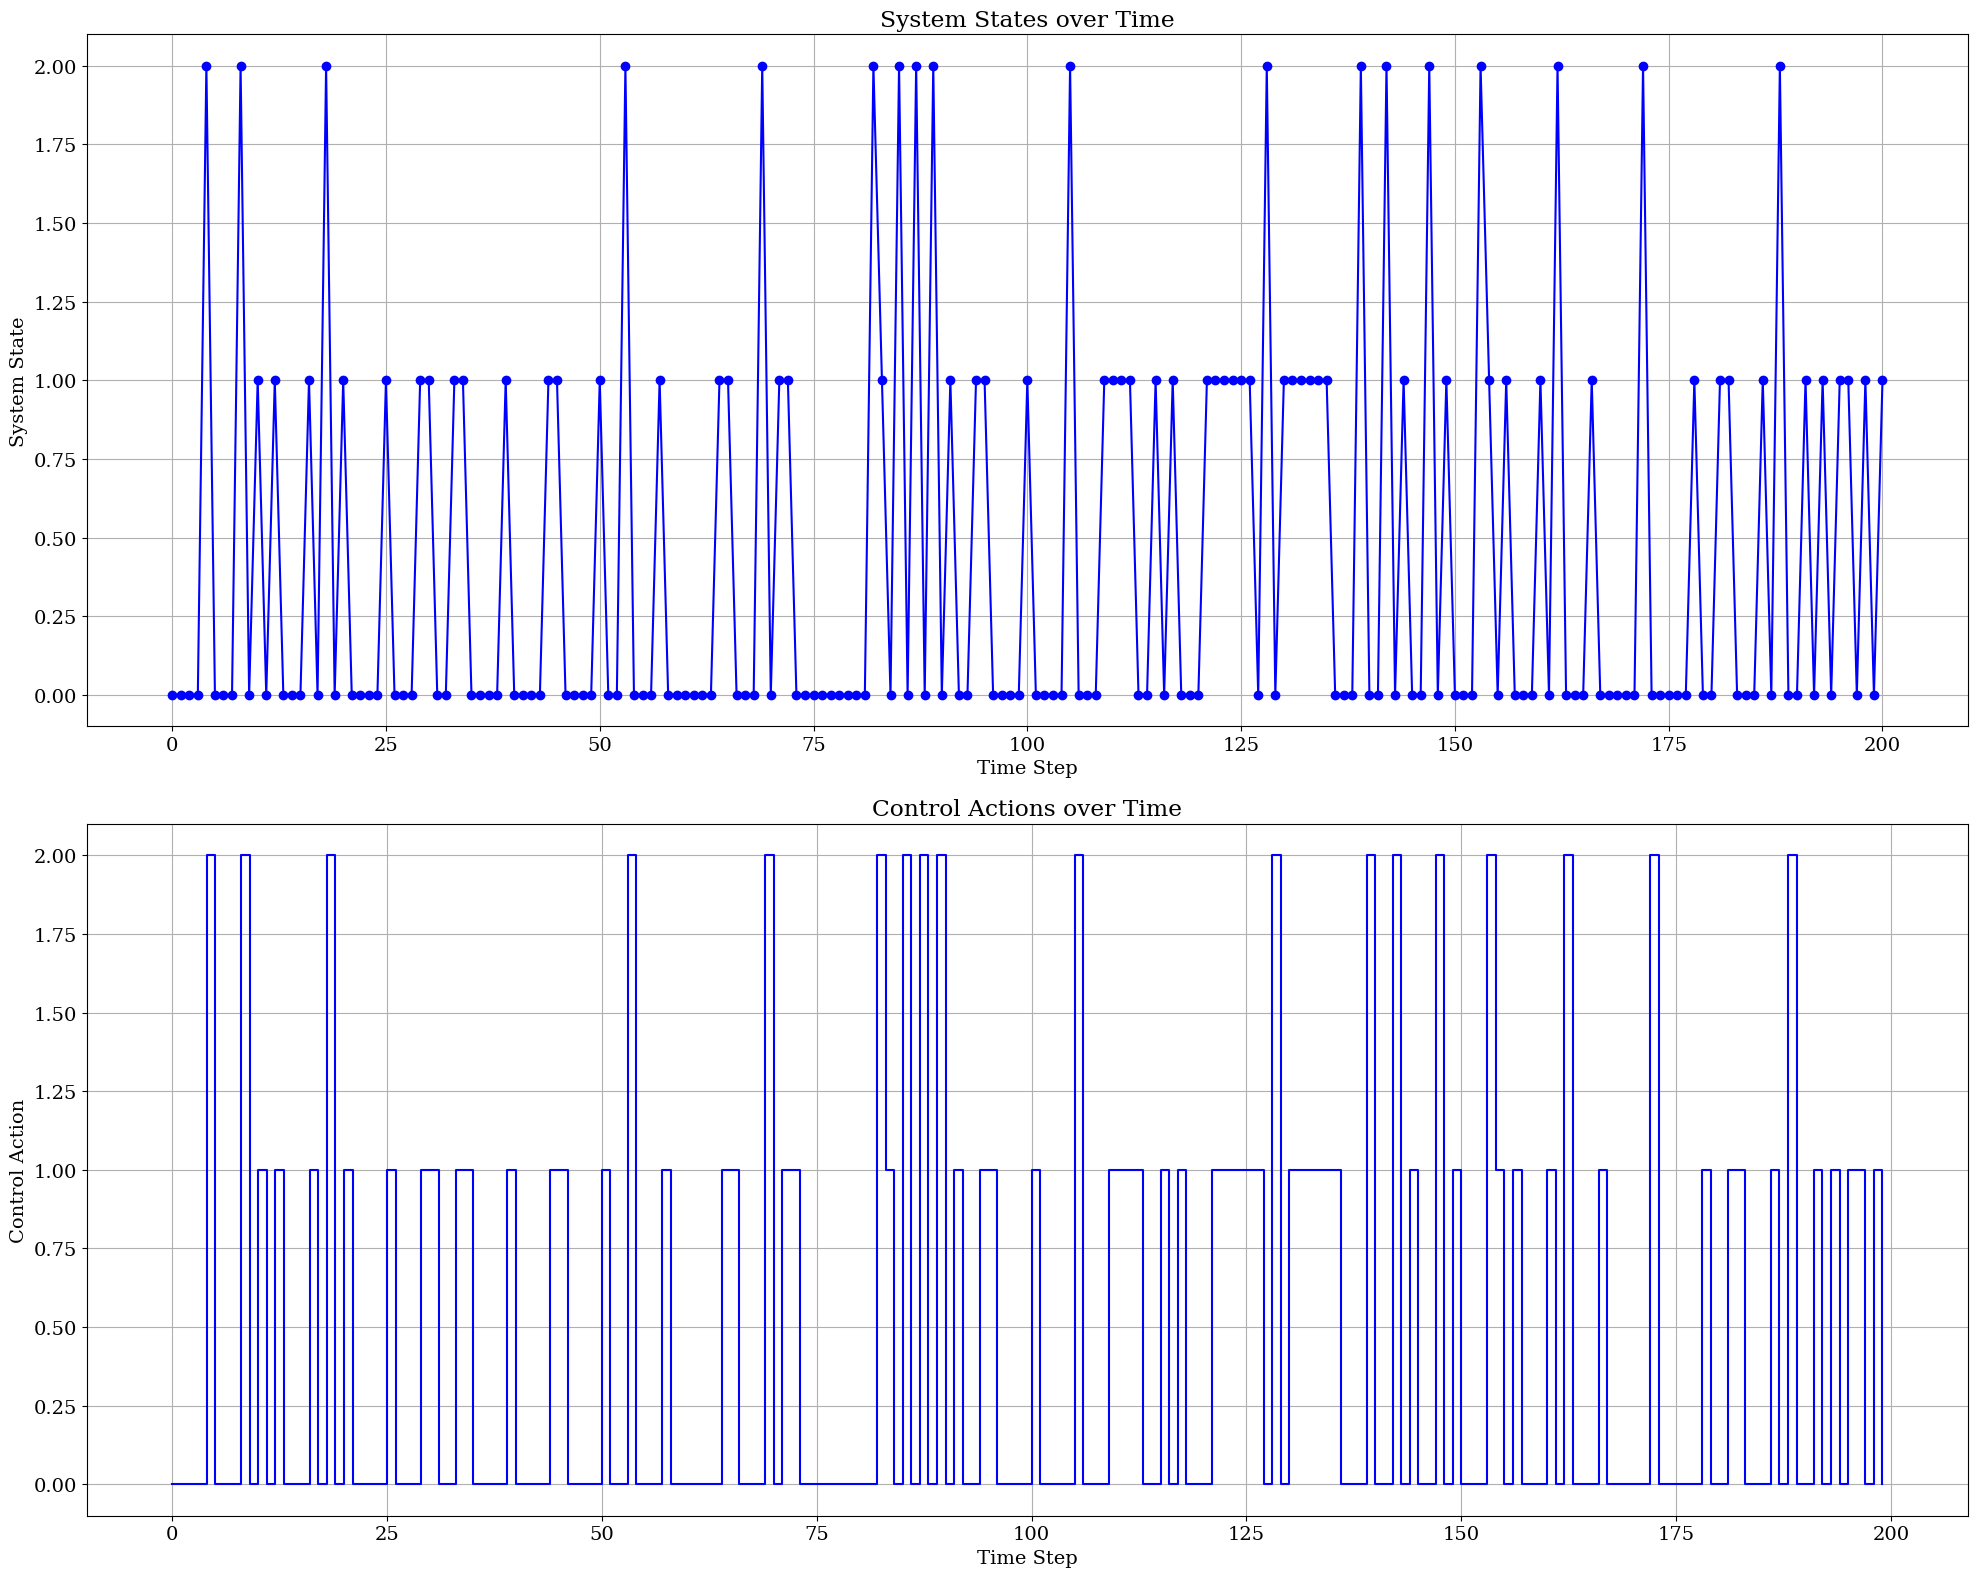

In [7]:
# @title #####__MARKOV DECISION PROCESS (MDP) - OPTIMAL POLICY DETERMINATION__

import numpy as np
import matplotlib.pyplot as plt

class DynamicSystemMDP:
    def __init__(self, num_states, num_actions, transition_matrix, reward_matrix, theta=0.001, discount_factor=0.9):
        self.num_states = num_states
        self.num_actions = num_actions
        self.transition_matrix = transition_matrix
        self.reward_matrix = reward_matrix
        self.theta = theta
        self.discount_factor = discount_factor

    def get_transition_prob(self, state, action, next_state):
        return self.transition_matrix[state, action, next_state]

    def get_reward(self, state, action):
        return self.reward_matrix[state, action]

    def value_iteration_with_convergence(self):
        V = np.zeros(self.num_states)
        delta_history = []

        while True:
            delta = 0
            for s in range(self.num_states):
                v = V[s]
                V[s] = max(self.calculate_q_value(s, a, V, self.discount_factor) for a in range(self.num_actions))
                delta = max(delta, abs(v - V[s]))
            delta_history.append(delta)
            if delta < self.theta:
                break

        policy = np.zeros(self.num_states, dtype=int)
        for s in range(self.num_states):
            policy[s] = np.argmax([self.calculate_q_value(s, a, V, self.discount_factor) for a in range(self.num_actions)])

        return V, policy, delta_history

    def calculate_q_value(self, state, action, V, discount_factor):
        q_value = 0
        for next_state in range(self.num_states):
            q_value += self.get_transition_prob(state, action, next_state) * \
                       (self.get_reward(state, action) + discount_factor * V[next_state])
        return q_value

# Define states and actions
states = ["G", "F", "P"]
actions = ["D", "M", "R"]

# Define transition probabilities
transition_probabilities = {
    "G": {"D": {"G": 0.5, "F": 0.3, "P": 0.2},
          "M": {"G": 0.8, "F": 0.2, "P": 0.0},
          "R": {"G": 0.9, "F": 0.1, "P": 0.0}},

    "F": {"D": {"G": 0.0, "F": 0.6, "P": 0.4},
          "M": {"G": 0.6, "F": 0.4, "P": 0.0},
          "R": {"G": 0.9, "F": 0.1, "P": 0.0}},

    "P": {"D": {"G": 0.0, "F": 0.0, "P": 1.0},
          "M": {"G": 0.2, "F": 0.7, "P": 0.1},
          "R": {"G": 0.9, "F": 0.1, "P": 0.0}}
}

# Define rewards
rewards = {
    "G": {"D":  -1, "M":  -5, "R": -25},
    "F": {"D": -10, "M":  -5, "R": -10},
    "P": {"D": -25, "M": -10, "R": -10}
}

# Convert transition probabilities and rewards into numpy arrays for easier access
def convert_to_numpy(states, actions, transition_probabilities, rewards):
    num_states = len(states)
    num_actions = len(actions)

    transition_matrix = np.zeros((num_states, num_actions, num_states))
    reward_matrix = np.zeros((num_states, num_actions))

    for i, state in enumerate(states):
        for j, action in enumerate(actions):
            for k, next_state in enumerate(states):
                transition_matrix[i, j, k] = transition_probabilities[state][action][next_state]
            reward_matrix[i, j] = rewards[state][action]

    return transition_matrix, reward_matrix

transition_matrix, reward_matrix = convert_to_numpy(states, actions, transition_probabilities, rewards)

mdp = DynamicSystemMDP(len(states), len(actions), transition_matrix, reward_matrix)

# Perform value iteration to find optimal policy
optimal_values, optimal_policy, convergence_history = mdp.value_iteration_with_convergence()

cumulative_reward = np.zeros(len(convergence_history))
current_reward = 0
for i in range(len(convergence_history)):
    current_reward += convergence_history[i]
    cumulative_reward[i] = current_reward

# Plot convergence history
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 6))
plt.plot(range(len(convergence_history)), convergence_history, label='Max. Change in Value Function', color='red')
plt.plot(range(len(convergence_history)), cumulative_reward, label='Cumulative Reward', color='blue')
plt.hlines(mdp.theta, 0.0, len(convergence_history), colors='black', alpha=0.6)
plt.text(len(convergence_history) * 0.95, mdp.theta, r'$\theta = {}$'.format(mdp.theta), ha='right', va='bottom')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Convergence Plot')
plt.legend(loc='center right')
#plt.yscale('log')
plt.grid()
plt.show()



# Define function to simulate the system----------------------------------------

def simulate_system(mdp, initial_state, policy, num_steps):
    states = [initial_state]
    actions = []
    rewards = []

    state = initial_state
    for _ in range(num_steps):
        action = policy[state]
        next_state = np.random.choice(range(mdp.num_states), p=mdp.transition_matrix[state, action])
        reward = mdp.get_reward(state, action)

        states.append(next_state)
        actions.append(action)
        rewards.append(reward)

        state = next_state

    return states, actions, rewards


initial_state = 0
num_steps = 200
system_states, control_actions, rewards = simulate_system(mdp, initial_state, optimal_policy, num_steps)

# Visualize system states and control actions
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 16))
plt.subplot(2, 1, 1)
plt.plot(range(num_steps + 1), system_states, marker='o', color='blue')
plt.xlabel('Time Step')
plt.ylabel('System State')
plt.title('System States over Time')
plt.grid()

plt.subplot(2, 1, 2)
plt.step(range(num_steps), control_actions, where='post', color='blue')
plt.xlabel('Time Step')
plt.ylabel('Control Action')
plt.title('Control Actions over Time')

plt.grid()
plt.tight_layout()
plt.show()


###__MDP System Estimation from data__

In this section it is shown how the transition matrix can also be identified for a discrete system with control, a comparison will then be made with the real matrix as carried out above.

Transition Probabilities Matrix Estimated for MDP

[[[0.49568552 0.29530201 0.20901246]
  [0.78949881 0.21050119 0.        ]
  [0.89398959 0.10601041 0.        ]]

 [[0.         0.61922141 0.38077859]
  [0.58060606 0.41939394 0.        ]
  [0.90617849 0.09382151 0.        ]]

 [[0.         0.         1.        ]
  [0.20734908 0.7007874  0.09186352]
  [0.91089109 0.08910891 0.        ]]]

Reward Matrix Estimated for MDP

[[ -1.  -5. -25.]
 [-10.  -5. -10.]
 [-25. -10. -10.]]



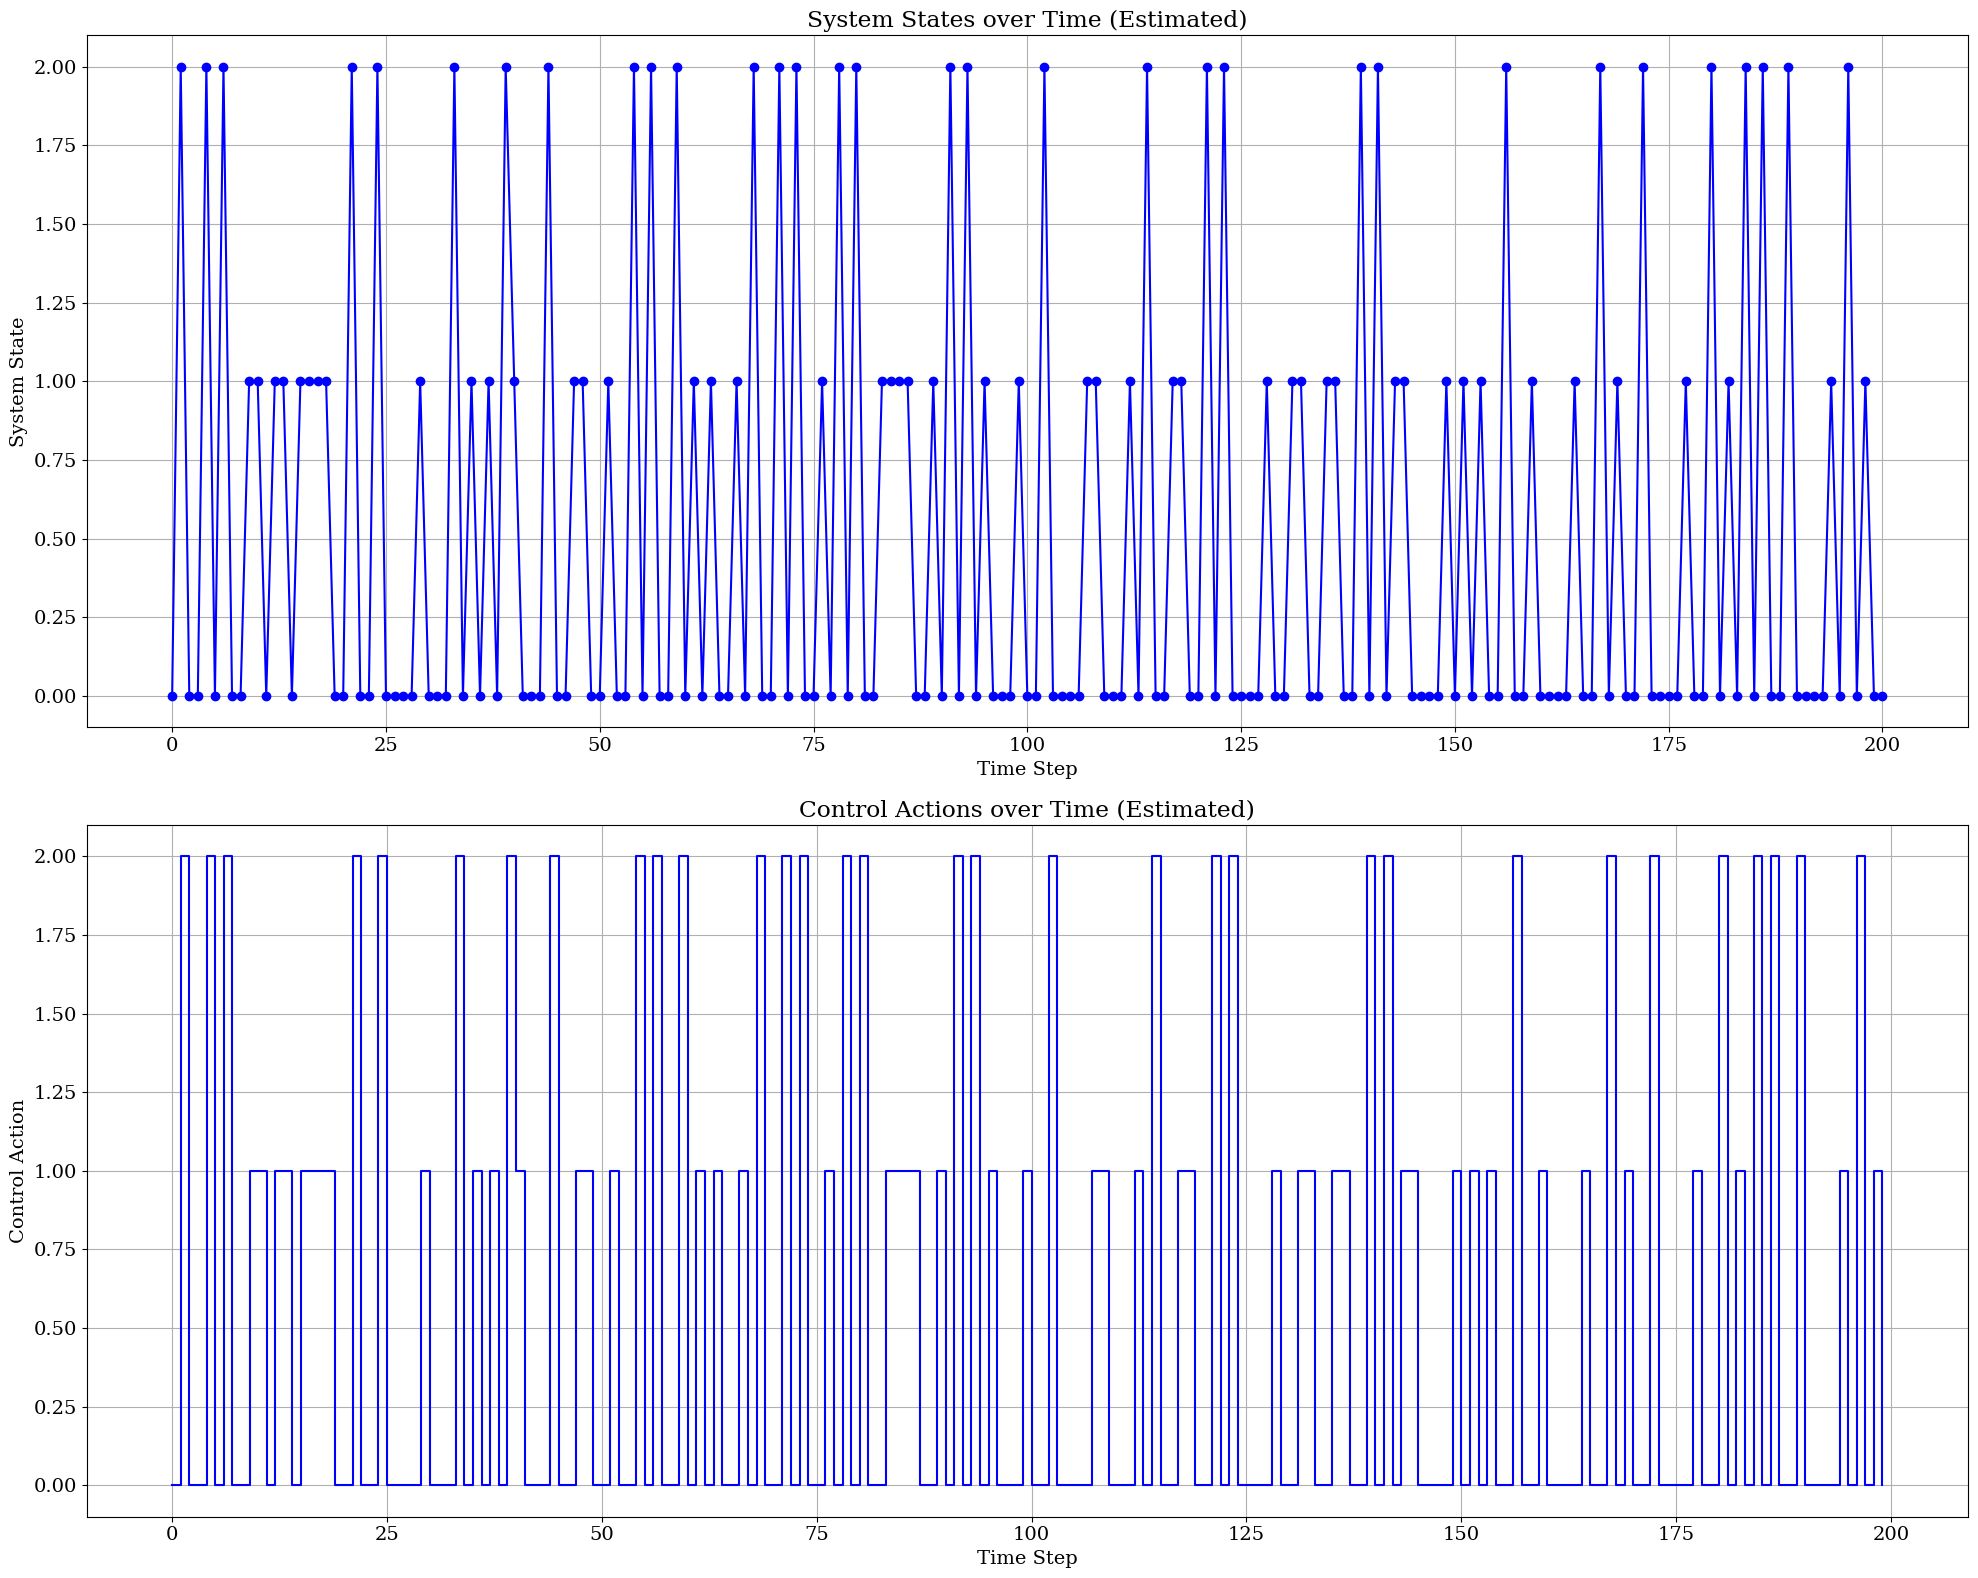

In [8]:
# @title #####__ESTIMATION OF TRANSITION PROBABILITY MATRIX FROM DATA (MLE METHOD)__


import numpy as np
import matplotlib.pyplot as plt

class DynamicSystemMDP:
    def __init__(self, num_states, num_actions, transition_matrix, reward_matrix, theta=0.001, discount_factor=0.9):
        self.num_states = num_states
        self.num_actions = num_actions
        self.transition_matrix = transition_matrix
        self.reward_matrix = reward_matrix
        self.theta = theta
        self.discount_factor = discount_factor

    def get_transition_prob(self, state, action, next_state):
        return self.transition_matrix[state, action, next_state]

    def get_reward(self, state, action):
        return self.reward_matrix[state, action]

    def value_iteration_with_convergence(self):
        V = np.zeros(self.num_states)
        delta_history = []

        while True:
            delta = 0
            for s in range(self.num_states):
                v = V[s]
                V[s] = max(self.calculate_q_value(s, a, V, self.discount_factor) for a in range(self.num_actions))
                delta = max(delta, abs(v - V[s]))
            delta_history.append(delta)
            if delta < self.theta:
                break

        policy = np.zeros(self.num_states, dtype=int)
        for s in range(self.num_states):
            policy[s] = np.argmax([self.calculate_q_value(s, a, V, self.discount_factor) for a in range(self.num_actions)])

        return V, policy, delta_history

    def calculate_q_value(self, state, action, V, discount_factor):
        q_value = 0
        for next_state in range(self.num_states):
            q_value += self.get_transition_prob(state, action, next_state) * \
                       (self.get_reward(state, action) + discount_factor * V[next_state])
        return q_value


states = ["G", "F", "P"]
actions = ["D", "M", "R"]

transition_probabilities = {
    "G": {"D": {"G": 0.5, "F": 0.3, "P": 0.2},
          "M": {"G": 0.8, "F": 0.2, "P": 0.0},
          "R": {"G": 0.9, "F": 0.1, "P": 0.0}},

    "F": {"D": {"G": 0.0, "F": 0.6, "P": 0.4},
          "M": {"G": 0.6, "F": 0.4, "P": 0.0},
          "R": {"G": 0.9, "F": 0.1, "P": 0.0}},

    "P": {"D": {"G": 0.0, "F": 0.0, "P": 1.0},
          "M": {"G": 0.2, "F": 0.7, "P": 0.1},
          "R": {"G": 0.9, "F": 0.1, "P": 0.0}}
}

rewards = {
    "G": {"D":  -1, "M":  -5, "R": -25},
    "F": {"D": -10, "M":  -5, "R": -10},
    "P": {"D": -25, "M": -10, "R": -10}
}

def convert_to_numpy(states, actions, transition_probabilities, rewards):
    num_states = len(states)
    num_actions = len(actions)

    transition_matrix = np.zeros((num_states, num_actions, num_states))
    reward_matrix = np.zeros((num_states, num_actions))

    for i, state in enumerate(states):
        for j, action in enumerate(actions):
            for k, next_state in enumerate(states):
                transition_matrix[i, j, k] = transition_probabilities[state][action][next_state]
            reward_matrix[i, j] = rewards[state][action]

    return transition_matrix, reward_matrix

transition_matrix, reward_matrix = convert_to_numpy(states, actions, transition_probabilities, rewards)

# Generate data using the provided transition matrix----------------------------
def generate_data(mdp, num_samples):
    data = []
    state = np.random.randint(mdp.num_states)  # Random initial state
    for _ in range(num_samples):
        action = np.random.randint(mdp.num_actions)  # Random action
        next_state = np.random.choice(range(mdp.num_states), p=mdp.transition_matrix[state, action])
        data.append((state, action, next_state))
        state = next_state
    return data

num_samples = 10000
data = generate_data(mdp, num_samples)

# Estimate transition and reward matrices from data
def estimate_matrices_from_data(data, num_states, num_actions):
    # Count transitions for each state-action pair
    transition_counts = np.zeros((num_states, num_actions, num_states))
    reward_sums = np.zeros((num_states, num_actions))
    reward_counts = np.zeros((num_states, num_actions))

    for state, action, next_state in data:
        transition_counts[state, action, next_state] += 1
        reward_sums[state, action] += reward_matrix[state, action]
        reward_counts[state, action] += 1

    # Normalize transition counts to obtain transition probabilities
    transition_matrix_estimated = transition_counts / np.sum(transition_counts, axis=2, keepdims=True)

    # Calculate average rewards for each state-action pair
    reward_matrix_estimated = np.where(reward_counts > 0, reward_sums / reward_counts, 0)

    return transition_matrix_estimated, reward_matrix_estimated

transition_matrix_estimated, reward_matrix_estimated = estimate_matrices_from_data(data, len(states), len(actions))

print('Transition Probabilities Matrix Estimated for MDP'), print()
print(transition_matrix_estimated), print()
print('Reward Matrix Estimated for MDP'), print()
print(reward_matrix_estimated), print()

mdp_estimated = DynamicSystemMDP(len(states), len(actions), transition_matrix_estimated, reward_matrix_estimated)
optimal_values_estimated, optimal_policy_estimated, convergence_history_estimated = mdp_estimated.value_iteration_with_convergence()

# Define function to simulate the system using estimated policy-----------------
def simulate_system_estimated(mdp, initial_state, policy, num_steps):
    states = [initial_state]
    actions = []
    rewards = []

    state = initial_state
    for _ in range(num_steps):
        action = policy[state]
        next_state = np.random.choice(range(mdp.num_states), p=mdp.transition_matrix[state, action])
        reward = mdp.get_reward(state, action)

        states.append(next_state)
        actions.append(action)
        rewards.append(reward)

        state = next_state

    return states, actions, rewards

initial_state = 0

num_steps = 200
system_states_estimated, control_actions_estimated, rewards_estimated = simulate_system_estimated(mdp_estimated, initial_state, optimal_policy_estimated, num_steps)

plt.figure(figsize=(20, 16))
plt.subplot(2, 1, 1)
plt.plot(range(num_steps + 1), system_states_estimated, marker='o', color='blue')
plt.xlabel('Time Step')
plt.ylabel('System State')
plt.title('System States over Time (Estimated)')
plt.grid()

plt.subplot(2, 1, 2)
plt.step(range(num_steps), control_actions_estimated, where='post', color='blue')
plt.xlabel('Time Step')
plt.ylabel('Control Action')
plt.title('Control Actions over Time (Estimated)')
plt.grid()
plt.tight_layout()
plt.show()


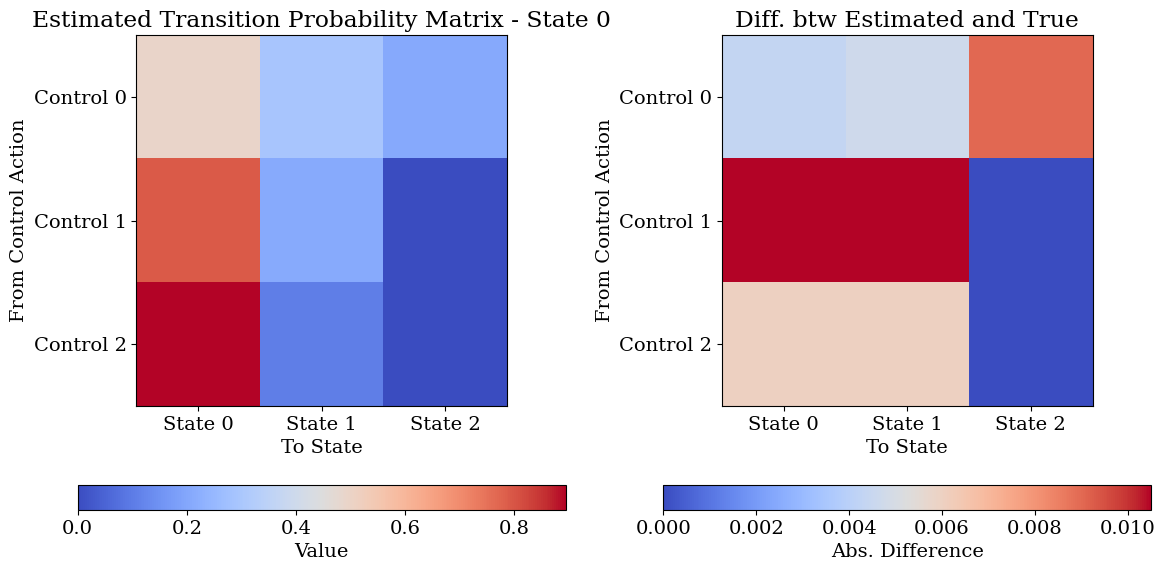

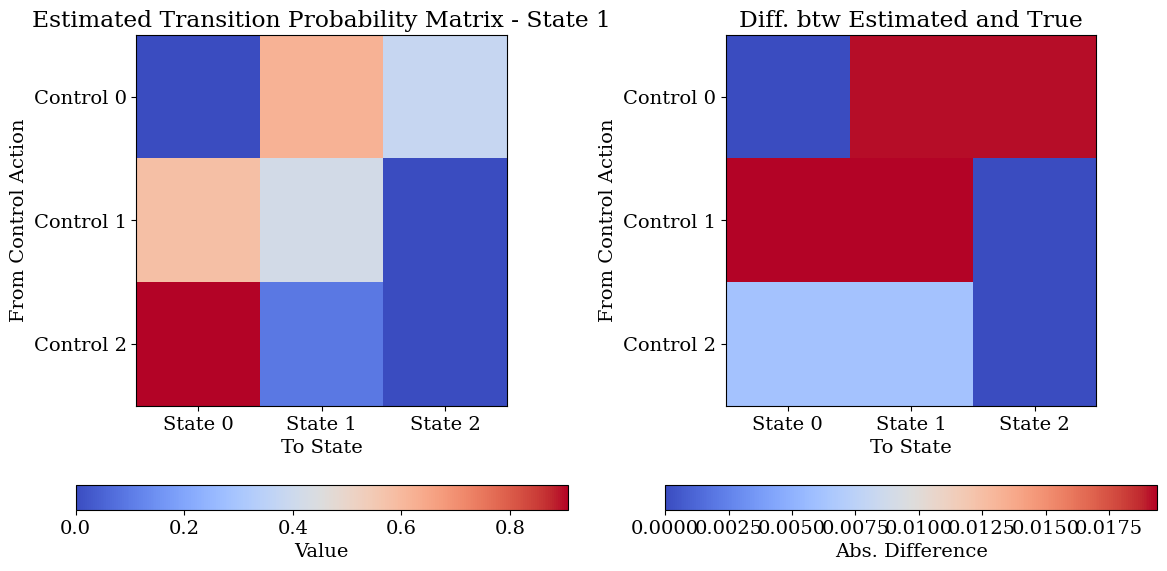

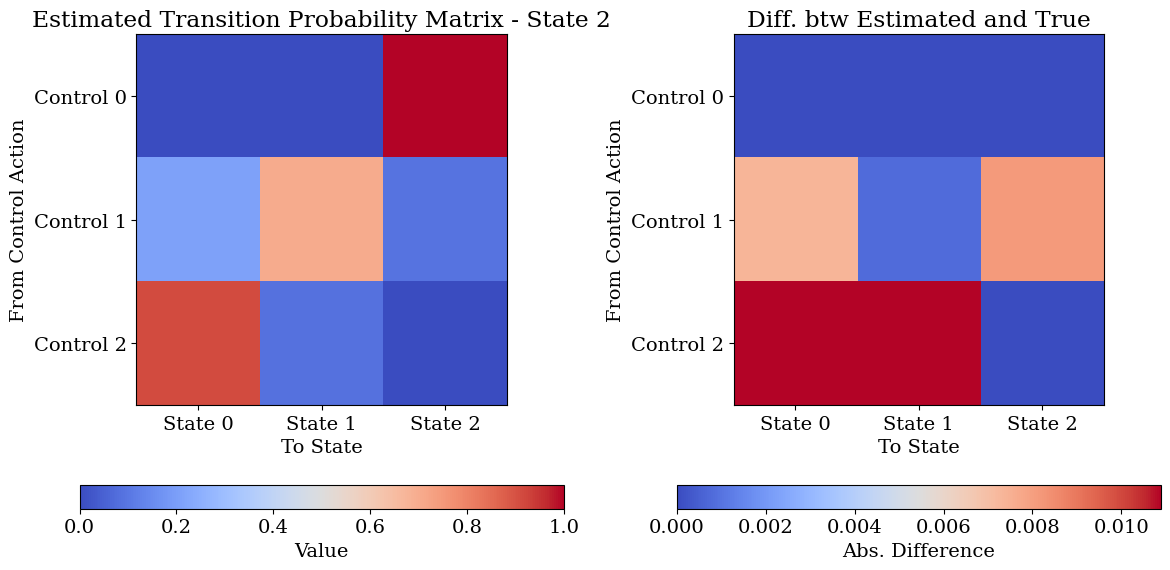

In [9]:
# @title #####__PLOT ESTIMATED TRANSITION PROBABILITY MATRIX W/ ABS ERROR__


difference_matrix = np.abs(transition_matrix_estimated[0][:][:] - transition_matrix[0][:][:])
# Plot the difference matrix as a colored grid
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot estimated transition probability matrix
axes[0].imshow(transition_matrix_estimated[0][:][:], cmap='coolwarm', interpolation='nearest')
axes[0].set_title('Estimated Transition Probability Matrix - State 0')
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From Control Action')
axes[0].set_xticks(np.arange(3))
axes[0].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[0].set_yticks(np.arange(3))
axes[0].set_yticklabels(['Control 0', 'Control 1', 'Control 2'])
axes[0].grid(False)
plt.colorbar(axes[0].imshow(transition_matrix_estimated[0][:][:], cmap='coolwarm', interpolation='nearest'), ax=axes[0], label='Value', orientation='horizontal')

# Plot difference matrix
im = axes[1].imshow(difference_matrix, cmap='coolwarm', interpolation='nearest')
axes[1].set_title('Diff. btw Estimated and True')
axes[1].set_xlabel('To State')
axes[1].set_ylabel('From Control Action')
axes[1].set_xticks(np.arange(3))
axes[1].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[1].set_yticks(np.arange(3))
axes[1].set_yticklabels(['Control 0', 'Control 1', 'Control 2'])
axes[1].grid(False)
plt.colorbar(im, ax=axes[1], label='Abs. Difference', orientation='horizontal')

plt.tight_layout()
plt.show()

#-------------------------------------------------------------------------------

difference_matrix = np.abs(transition_matrix_estimated[1][:][:] - transition_matrix[1][:][:])
# Plot the difference matrix as a colored grid
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot estimated transition probability matrix
axes[0].imshow(transition_matrix_estimated[1][:][:], cmap='coolwarm', interpolation='nearest')
axes[0].set_title('Estimated Transition Probability Matrix - State 1')
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From Control Action')
axes[0].set_xticks(np.arange(3))
axes[0].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[0].set_yticks(np.arange(3))
axes[0].set_yticklabels(['Control 0', 'Control 1', 'Control 2'])
axes[0].grid(False)
plt.colorbar(axes[0].imshow(transition_matrix_estimated[1][:][:], cmap='coolwarm', interpolation='nearest'), ax=axes[0], label='Value', orientation='horizontal')

# Plot difference matrix
im = axes[1].imshow(difference_matrix, cmap='coolwarm', interpolation='nearest')
axes[1].set_title('Diff. btw Estimated and True')
axes[1].set_xlabel('To State')
axes[1].set_ylabel('From Control Action')
axes[1].set_xticks(np.arange(3))
axes[1].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[1].set_yticks(np.arange(3))
axes[1].set_yticklabels(['Control 0', 'Control 1', 'Control 2'])
axes[1].grid(False)
plt.colorbar(im, ax=axes[1], label='Abs. Difference', orientation='horizontal')

plt.tight_layout()
plt.show()

#-------------------------------------------------------------------------------

difference_matrix = np.abs(transition_matrix_estimated[2][:][:] - transition_matrix[2][:][:])
# Plot the difference matrix as a colored grid
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot estimated transition probability matrix
axes[0].imshow(transition_matrix_estimated[2][:][:], cmap='coolwarm', interpolation='nearest')
axes[0].set_title('Estimated Transition Probability Matrix - State 2')
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From Control Action')
axes[0].set_xticks(np.arange(3))
axes[0].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[0].set_yticks(np.arange(3))
axes[0].set_yticklabels(['Control 0', 'Control 1', 'Control 2'])
axes[0].grid(False)
plt.colorbar(axes[0].imshow(transition_matrix_estimated[2][:][:], cmap='coolwarm', interpolation='nearest'), ax=axes[0], label='Value', orientation='horizontal')

# Plot difference matrix
im = axes[1].imshow(difference_matrix, cmap='coolwarm', interpolation='nearest')
axes[1].set_title('Diff. btw Estimated and True')
axes[1].set_xlabel('To State')
axes[1].set_ylabel('From Control Action')
axes[1].set_xticks(np.arange(3))
axes[1].set_xticklabels(['State 0', 'State 1', 'State 2'])
axes[1].set_yticks(np.arange(3))
axes[1].set_yticklabels(['Control 0', 'Control 1', 'Control 2'])
axes[1].grid(False)
plt.colorbar(im, ax=axes[1], label='Abs. Difference', orientation='horizontal')

plt.tight_layout()
plt.show()




---

